In [183]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [184]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


/tmp/ipykernel_31/2474669002.py:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [185]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {len(gpus)}")
    print("Details:", gpus)
else:
    print("No GPU found.")


GPUs available: 2
Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [186]:
df = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

In [187]:
!nvidia-smi


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Thu Oct 17 16:22:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             31W /   70W |   14059MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [188]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [189]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

/tmp/ipykernel_31/1259316306.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [190]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [191]:
df = df[['OriginalTweet','Sentiment']]


In [192]:
df_test = df_test[['OriginalTweet','Sentiment']]
print(df_test.head())

                                       OriginalTweet           Sentiment
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative
1  When I couldn't find hand sanitizer at Fred Me...            Positive
2  Find out how you can protect yourself and love...  Extremely Positive
3  #Panic buying hits #NewYork City as anxious sh...            Negative
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral


In [193]:
#Clean emojis from text
import emoji
def strip_emoji(text):
    return emoji.replace_emoji(text, replace='') 

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [194]:
import emoji

texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


In [195]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [196]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [197]:
df['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [198]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [199]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [200]:
text_len = []  ##number of word in every sentence 
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [201]:
df['text_len'] = text_len

In [202]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [203]:
df_test['text_len'] = text_len_test

In [204]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [205]:
df = df[df['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4] 
#if there are text its size =0 after cleaning 

In [206]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")
print(df_test.head())

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)
                                       OriginalTweet           Sentiment  \
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative   
1  When I couldn't find hand sanitizer at Fred Me...            Positive   
2  Find out how you can protect yourself and love...  Extremely Positive   
3  #Panic buying hits #NewYork City as anxious sh...            Negative   
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral   

                                          text_clean  text_len  
0  trending new yorkers encounter empty supermark...        21  
1  when i couldnt find hand sanitizer at fred mey...        29  
2  find out how you can protect yourself and love...        12  
3  panic buying hits newyork city as anxious shop...        35  
4  toiletpaper dunnypaper coronavirus coronavirus...        25  


In [207]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [208]:
token_lens = []
#omputing the maximum token length of the text data in the text_clean column
for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [209]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


**Let's check the long tokenized sentences (with more than 80 tokens ):**

In [210]:
token_lens = []
#this text not english so drop them
for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

In [211]:
df['token_lens'] = token_lens

In [212]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [213]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76


In [214]:
df = df.sample(frac=1).reset_index(drop=True) #sample from train set

In [215]:
print(df.head())


                                       OriginalTweet           Sentiment  \
0  Washing hands is better than sanitizer gang. #...            Positive   
1  If petrol prices drop any further, Reliance ma...            Negative   
2  IÂm seriously thinking of doing #ReadySteadyC...            Negative   
3  Home prices unlikely to decline much during th...            Negative   
4  Whats up with #china ???\r\r\n#XiJinping now w...  Extremely Negative   

                                          text_clean  text_len  token_lens  
0  washing hands is better than sanitizer gang co...         9          17  
1  if petrol prices drop any further reliance may...        19          27  
2  im seriously thinking of doing readysteadycook...        42          51  
3  home prices unlikely to decline much during th...        25          28  
4  whats up with china xijinping now wearing mask...        14          22  


In [216]:
#test
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [217]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 96


In [218]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [219]:
df_test['token_lens'] = token_lens_test

In [220]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [221]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [222]:
df_test = df_test.sample(frac=1).reset_index(drop=True)#sample from test set

In [223]:
df['Sentiment'].value_counts()

Sentiment
Positive              11381
Negative               9889
Neutral                7560
Extremely Positive     6618
Extremely Negative     5475
Name: count, dtype: int64

In [224]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [225]:
df["Sentiment"].value_counts()


Sentiment
2    17999
0    15364
1     7560
Name: count, dtype: int64

In [226]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [227]:
df_test['Sentiment'].value_counts()


Sentiment
0    1629
2    1544
1     614
Name: count, dtype: int64

In [228]:
#for class balancing
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [229]:
train_os['Sentiment'].value_counts()

Sentiment
2    17999
0    17999
1    17999
Name: count, dtype: int64

In [230]:
#train
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [231]:
print(np.unique(y))#training

[0 1 2]


In [232]:
#train validationi
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [233]:
#test
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values
print(np.unique(X_test))
print(np.unique(y_test))

['0 chance of any premier league games happening this weekend they wouldnt dare and they shouldnt we already get shafted with ticket prices dont have the audacity to play through a pandemic as well covid19 coronaviruspandemic'
 '1 a wellstocked supermarket 2 the same supermarket just 2 minutes later shopping is like a military operation at the minute sainsburys aldi morrisons panicbuying panicbuyinguk coronaviruspandemic covid19 coronavirusinuk'
 '1 all this looks like a postapocalyptic brated movie where it starts with pieces of news panic fight over food and resources and then screen coes blank it writes 1 year later a deserted city with empty cars crashed and piled up trash covid19 coronaviruspandemic'
 ...
 'youve seen higher prices for hand sanitizer since coronavirus is that pricegouging your airline cruise line or wedding venue wont let you reschedule what are your rights and how to distinguish covid19 myths from truth join me live on fb at 1230pm for consumer qampa'
 'zimbabwea

In [234]:
#use one hot encodingy_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()


In [235]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_valid:", np.unique(y_valid))
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_train: [0 1 2]
Unique values in y_valid: [0 1 2]
Unique values in y_test: [0 1 2]


In [236]:
print("Shape of y_train:", y_train.shape)
print("Shape of y_valid:", y_valid.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train: (48597,)
Shape of y_valid: (5400,)
Shape of y_test: (3787,)


In [237]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_valid:", np.unique(y_valid))
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_train: [0 1 2]
Unique values in y_valid: [0 1 2]
Unique values in y_test: [0 1 2]


In [238]:
# Initialize the OneHotEncoder
ohe = preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore')

# Reshape the labels to be 2D for fitting
y_train_reshaped = np.array(y_train).reshape(-1, 1)
y_valid_reshaped = np.array(y_valid).reshape(-1, 1)
y_test_reshaped = np.array(y_test).reshape(-1, 1)

# Fit and transform on the training data
y_train_encoded = ohe.fit_transform(y_train_reshaped)

# Transform validation and test data using the already fitted encoder
y_valid_encoded = ohe.transform(y_valid_reshaped)
y_test_encoded = ohe.transform(y_test_reshaped)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [239]:
print("Shape of y_train after encoding:", y_train_encoded.shape)  # Should be (48597, 3)
print("Shape of y_valid after encoding:", y_valid_encoded.shape)  # Should be (5400, 3)
print("Shape of y_test after encoding:", y_test_encoded.shape)  

Shape of y_train after encoding: (48597, 3)
Shape of y_valid after encoding: (5400, 3)
Shape of y_test after encoding: (3787, 3)


In [240]:
# Count unique values in the one-hot encoded arrays
print("Counts in y_train_encoded:", np.bincount(y_train_encoded.argmax(axis=1)))
print("Counts in y_valid_encoded:", np.bincount(y_valid_encoded.argmax(axis=1)))
print("Counts in y_test_encoded:", np.bincount(y_test_encoded.argmax(axis=1)))

Counts in y_train_encoded: [16199 16199 16199]
Counts in y_valid_encoded: [1800 1800 1800]
Counts in y_test_encoded: [1629  614 1544]


In [241]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48597
VALIDATION DATA: 5400
TESTING DATA: 3787


In [242]:
MAX_LEN=128

In [243]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [244]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

**Bert model**

In [245]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [246]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [247]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_5[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_6[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [248]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [249]:
print("Shape of y_train after encoding:", y_train_encoded.shape)  # Should be (48597, 3)
print("Shape of y_valid after encoding:", y_valid_encoded.shape)  # Should be (5400, 3)
print("Shape of y_test after encoding:", y_test_encoded.shape)  

Shape of y_train after encoding: (48597, 3)
Shape of y_valid after encoding: (5400, 3)
Shape of y_test after encoding: (3787, 3)


In [250]:
print("y_shape_train",y_train_encoded.shape)
print("y_shape_valid",y_valid_encoded.shape)
print("y_shape_test",y_test_encoded.shape)

y_shape_train (48597, 3)
y_shape_valid (5400, 3)
y_shape_test (3787, 3)


In [251]:
# Count unique values in the one-hot encoded arrays
print("Counts in y_train_encoded:", np.bincount(y_train_encoded.argmax(axis=1)))
print("Counts in y_valid_encoded:", np.bincount(y_valid_encoded.argmax(axis=1)))
print("Counts in y_test_encoded:", np.bincount(y_test_encoded.argmax(axis=1)))

Counts in y_train_encoded: [16199 16199 16199]
Counts in y_valid_encoded: [1800 1800 1800]
Counts in y_test_encoded: [1629  614 1544]


In [261]:
##no early stop take to much time
history_bert = model.fit([train_input_ids,train_attention_masks], y_train_encoded, validation_data=([val_input_ids,val_attention_masks], y_valid_encoded), epochs=4, batch_size=32)

Epoch 1/4
1519/1519 [==============================] - 1314s 834ms/step - loss: 0.5670 - categorical_accuracy: 0.7725 - val_loss: 0.3450 - val_categorical_accuracy: 0.8767
Epoch 2/4
1519/1519 [==============================] - 1254s 826ms/step - loss: 0.2954 - categorical_accuracy: 0.8951 - val_loss: 0.2556 - val_categorical_accuracy: 0.9130
Epoch 3/4
1519/1519 [==============================] - 1255s 826ms/step - loss: 0.2013 - categorical_accuracy: 0.9292 - val_loss: 0.2209 - val_categorical_accuracy: 0.9269
Epoch 4/4
1519/1519 [==============================] - 1255s 826ms/step - loss: 0.1387 - categorical_accuracy: 0.9524 - val_loss: 0.2068 - val_categorical_accuracy: 0.9385


**BERT Results**

In [262]:
result_bert = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 44s 277ms/step


In [264]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [265]:
print(y_pred_bert.shape)

(3787, 3)


In [263]:
print("Shape of y_test:", y_test.shape)
print("First 10 values of y_test:", y_test[:10])
print("Shape of y_test_flat:", y_test_flat.shape)
print("First 10 values of y_test_flat:", y_test_flat[:10])



Shape of y_test: (3787,)
First 10 values of y_test: [2 2 2 2 2 2 0 2 2 2]
Shape of y_test_flat: (3787,)
First 10 values of y_test_flat: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [256]:
unique_y_test = np.unique(y_test_flat)
unique_y_pred = np.unique(y_pred_labels)
print("Unique values in y_test_flat:", unique_y_test)
print("Unique values in y_pred_labels:", unique_y_pred)


Unique values in y_test_flat: [1.]
Unique values in y_pred_labels: [0 1 2]


In [266]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [258]:
# # Ensure that y_test is a flat array of integer labels
# y_test_flat = y_test.ravel()

# # Convert y_pred_bert to integer labels
# y_pred_labels = y_pred_bert.argmax(1)

# # Generate the confusion matrix using the corrected labels
# conf_matrix(y_test_flat, y_pred_labels, 'BERT Sentiment Analysis\nConfusion Matrix')


In [269]:
print(y_test_encoded.shape)
print(y_pred_bert.shape)

(3787, 3)
(3787, 3)


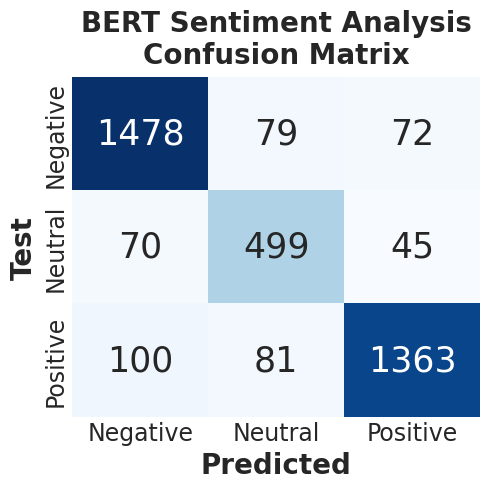

In [270]:
conf_matrix(y_test_encoded.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [272]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test_encoded,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.90      0.91      0.90      1629
     Neutral       0.76      0.81      0.78       614
    Positive       0.92      0.88      0.90      1544

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.86      0.87      0.86      3787
weighted avg       0.88      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787

